In [3]:
image_path = r"C:\Users\NiXoN\Downloads\sola.png" # BITTE ERSETZEN!


Bild erfolgreich geladen und vorbereitet: C:\Users\NiXoN\Downloads\sola.png
Originale Shape nach Laden: (735, 810, 3)
Shape nach Reskalieren auf 256x256: (256, 256, 3)


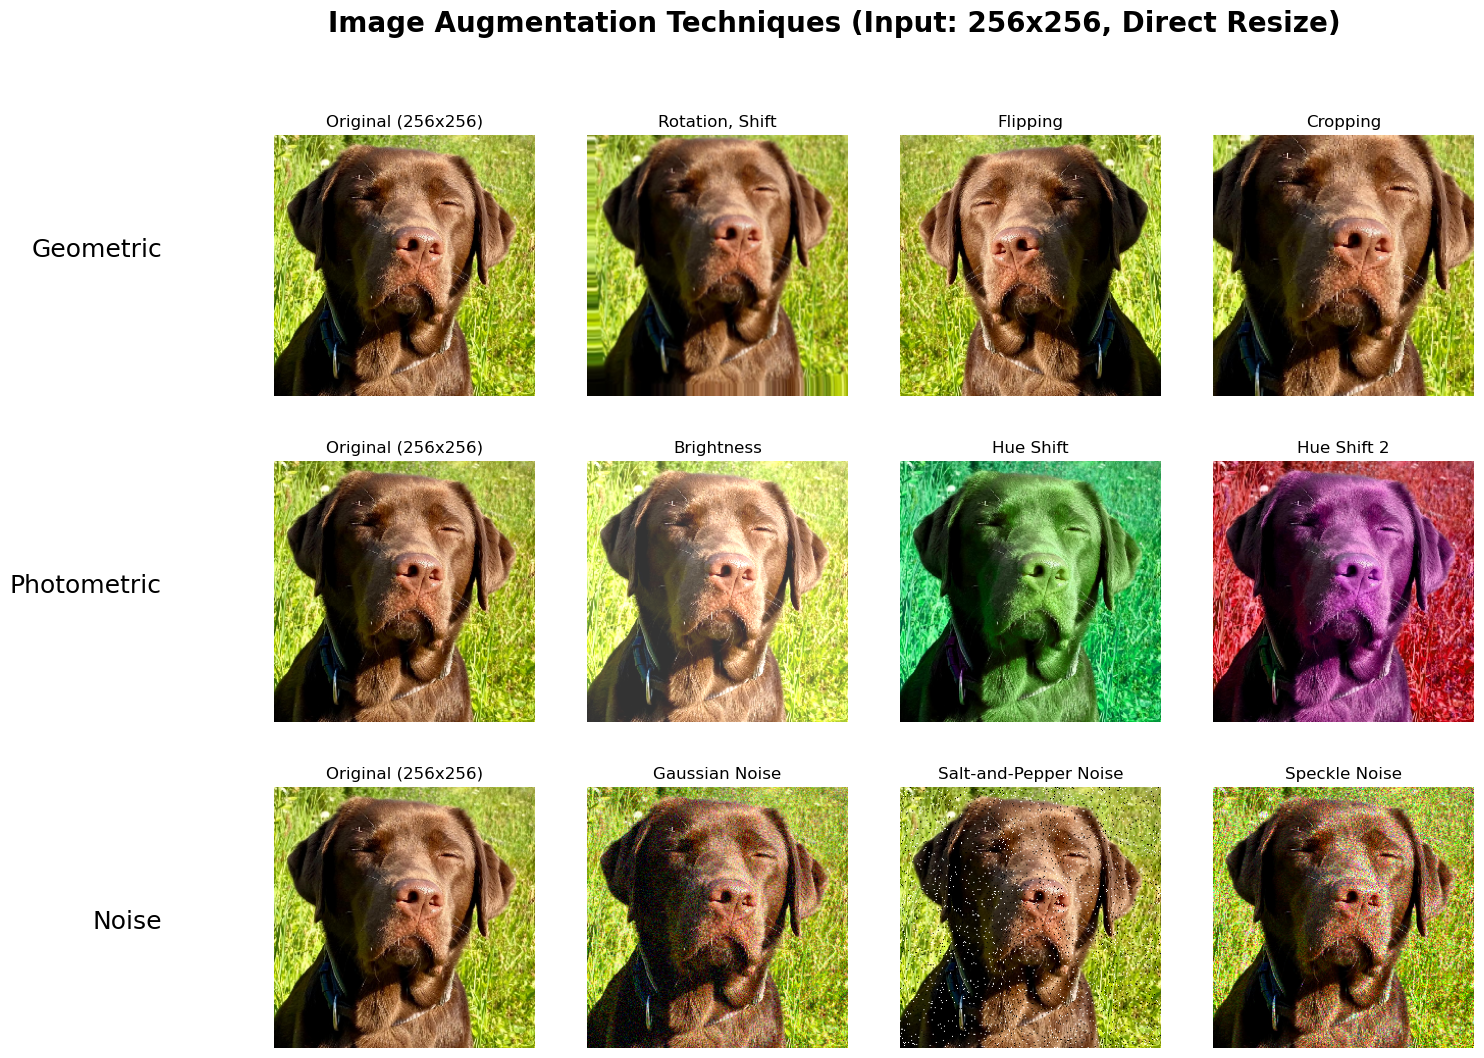

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- ANPASSUNG START: Bild von einem Windows-PC laden ---
TARGET_SIZE = 256 # Zielgröße für das Bild

try:
    img = load_img(image_path) # Standardmäßig RGB
    original_image_np = img_to_array(img) # Ist float32 nach img_to_array

    # Überprüfe die Dimensionen des Bildes
    if original_image_np.ndim != 3 or original_image_np.shape[2] != 3:
        raise ValueError("Das Bild muss ein RGB-Bild sein (3 Kanäle).")

    # Bild in Tensor konvertieren für tf.image Operationen
    original_image_tf = tf.convert_to_tensor(original_image_np, dtype=tf.float32)

    # --- ÄNDERUNG HIER: Direktes Reskalieren ohne Padding ---
    # Bild direkt auf TARGET_SIZE x TARGET_SIZE reskalieren.
    # Dies kann das Seitenverhältnis verzerren, wenn das Originalbild nicht quadratisch ist.
    resized_image_tf = tf.image.resize(
        original_image_tf,
        [TARGET_SIZE, TARGET_SIZE], # Definiert Höhe und Breite als Liste [height, width]
        method=tf.image.ResizeMethod.BILINEAR # oder andere Methoden wie NEAREST_NEIGHBOR, LANCZOS3 etc.
    )
    # --- ÄNDERUNG ENDE ---

    # Zurück zu NumPy Array und uint8 für die Augmentierungsfunktionen
    original_image = tf.cast(resized_image_tf, tf.uint8).numpy()

    print(f"Bild erfolgreich geladen und vorbereitet: {image_path}")
    print(f"Originale Shape nach Laden: {original_image_np.shape}")
    print(f"Shape nach Reskalieren auf {TARGET_SIZE}x{TARGET_SIZE}: {original_image.shape}")


except FileNotFoundError:
    print(f"FEHLER: Die Datei wurde nicht unter dem Pfad gefunden: {image_path}")
    print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
    exit()
except Exception as e:
    print(f"Ein Fehler ist beim Laden oder Vorbereiten des Bildes aufgetreten: {e}")
    exit()
# --- ANPASSUNG ENDE ---

# Augmentierungen anwenden
augmented_images = []

# Geometrische Augmentierungen
def rotate_shift(image_np):
    img_aug = tf.keras.preprocessing.image.random_rotation(image_np, 20, row_axis=0, col_axis=1, channel_axis=2)
    img_aug = tf.keras.preprocessing.image.random_shift(img_aug, 0.2, 0.2, row_axis=0, col_axis=1, channel_axis=2)
    return img_aug.astype(np.uint8)

def flip(image_np):
    img_tensor = tf.convert_to_tensor(image_np)
    return tf.image.flip_left_right(img_tensor).numpy().astype(np.uint8)

def crop(image_np):
    h, w, _ = image_np.shape
    start_h = int(h * 0.1) if h > 0 else 0
    start_w = int(w * 0.1) if w > 0 else 0
    end_h = int(h * 0.9) if h > start_h else h
    end_w = int(w * 0.9) if w > start_w else w

    if start_h >= end_h or start_w >= end_w:
        return image_np.astype(np.uint8)
    return image_np[start_h:end_h, start_w:end_w].astype(np.uint8)


augmented_images.append(rotate_shift(original_image.copy()))
augmented_images.append(flip(original_image.copy()))
augmented_images.append(crop(original_image.copy()))


# Photometrische Augmentierungen
def brightness(image_np):
    img_tensor = tf.convert_to_tensor(image_np, dtype=tf.uint8)
    adjusted_img = tf.image.adjust_brightness(img_tensor, 0.2)
    return tf.clip_by_value(adjusted_img, 0, 255).numpy().astype(np.uint8)


def hue_shift(image_np):
    img_float_tf = tf.image.convert_image_dtype(image_np, dtype=tf.float32)
    adjusted_img_tf = tf.image.adjust_hue(img_float_tf, 0.2)
    return (tf.image.convert_image_dtype(adjusted_img_tf, dtype=tf.uint8, saturate=True).numpy()).astype(np.uint8)

def hue_shift_2(image_np):
    img_float_tf = tf.image.convert_image_dtype(image_np, dtype=tf.float32)
    adjusted_img_tf = tf.image.adjust_hue(img_float_tf, -0.2)
    return (tf.image.convert_image_dtype(adjusted_img_tf, dtype=tf.uint8, saturate=True).numpy()).astype(np.uint8)


augmented_images.append(brightness(original_image.copy()))
augmented_images.append(hue_shift(original_image.copy()))
augmented_images.append(hue_shift_2(original_image.copy()))

# Noise-Corruption Augmentierungen
def add_gaussian_noise(image_np, mean=0, std=25):
    img_float = image_np.astype(np.float32)
    noise = np.random.normal(mean, std, img_float.shape)
    noisy_image = img_float + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def add_salt_pepper_noise(image_np, prob=0.05):
    noisy = image_np.copy()
    h, w, c = noisy.shape
    mask = np.random.choice((0, 1, 2), size=(h, w, 1), p=[1 - prob, prob / 2, prob / 2])
    if c > 1:
        mask = np.repeat(mask, c, axis=2)
    else:
        mask = mask.reshape(h,w)
    noisy[mask == 1] = 255
    noisy[mask == 2] = 0
    return noisy.astype(np.uint8)


def add_speckle_noise(image_np, prob = 0.3):
    img_float = image_np.astype(np.float32) / 255.0
    h, w, c = img_float.shape
    gauss = np.random.normal(0, prob, (h,w,c))
    noisy = img_float * (1 + gauss)
    noisy = np.clip(noisy * 255, 0, 255)
    return noisy.astype(np.uint8)


augmented_images.append(add_gaussian_noise(original_image.copy()))
augmented_images.append(add_salt_pepper_noise(original_image.copy()))
augmented_images.append(add_speckle_noise(original_image.copy()))


processed_augmented_images = []
for aug_img in augmented_images:
    if aug_img.shape[0] == 0 or aug_img.shape[1] == 0 :
        print("Warnung: Eine Augmentierung (wahrscheinlich Cropping) hat ein leeres Bild erzeugt. Originalbild wird stattdessen verwendet.")
        processed_augmented_images.append(original_image.astype(np.uint8))
    elif aug_img.ndim == 2:
        processed_augmented_images.append(np.stack((aug_img,)*3, axis=-1).astype(np.uint8))
    elif aug_img.shape[2] == 1:
         processed_augmented_images.append(np.repeat(aug_img, 3, axis=2).astype(np.uint8))
    else:
        processed_augmented_images.append(aug_img.astype(np.uint8))

augmented_images = processed_augmented_images

# Bilder visualisieren
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(3):
    axes[i, 0].imshow(original_image.astype(np.uint8))
    axes[i, 0].set_title(f"Original ({TARGET_SIZE}x{TARGET_SIZE})") # Titel angepasst
    axes[i, 0].axis("off")

axes[0, 1].imshow(augmented_images[0])
axes[0, 1].set_title("Rotation, Shift")
axes[0, 1].axis("off")
axes[0, 2].imshow(augmented_images[1])
axes[0, 2].set_title("Flipping")
axes[0, 2].axis("off")
axes[0, 3].imshow(augmented_images[2])
axes[0, 3].set_title("Cropping")
axes[0, 3].axis("off")

axes[1, 1].imshow(augmented_images[3])
axes[1, 1].set_title("Brightness")
axes[1, 1].axis("off")
axes[1, 2].imshow(augmented_images[4])
axes[1, 2].set_title("Hue Shift")
axes[1, 2].axis("off")
axes[1, 3].imshow(augmented_images[5])
axes[1, 3].set_title("Hue Shift 2")
axes[1, 3].axis("off")

axes[2, 1].imshow(augmented_images[6])
axes[2, 1].set_title("Gaussian Noise")
axes[2, 1].axis("off")
axes[2, 2].imshow(augmented_images[7])
axes[2, 2].set_title("Salt-and-Pepper Noise")
axes[2, 2].axis("off")
axes[2, 3].imshow(augmented_images[8])
axes[2, 3].set_title("Speckle Noise")
axes[2, 3].axis("off")

plt.figtext(0.08, 0.78, "Geometric", fontsize=18, ha="right", va="center")
plt.figtext(0.08, 0.5, "Photometric", fontsize=18, ha="right", va="center")
plt.figtext(0.08, 0.22, "Noise", fontsize=18, ha="right", va="center")

fig.suptitle(f'Image Augmentation Techniques (Input: {TARGET_SIZE}x{TARGET_SIZE}, Direct Resize)', fontsize=20, fontweight='bold', y=0.98) # Titel angepasst

plt.subplots_adjust(left=0.15)

plt.savefig(f'./traditional_image_augmentation_examples_{TARGET_SIZE}_direct_resize.png') # Dateiname angepasst
plt.show()